# DSC-037 step 4: Compute delay power spectra


---

**DSC-037**: Cable reflection systematics for EoR science

**Author:** Adélie Gorce and Teal team 

**Documentation on confluence:** 
- DSC description page: https://confluence.skatelescope.org/x/0rs6F
- Chronological walkthrough: https://confluence.skatelescope.org/x/osw6F
- Implementation: https://confluence.skatelescope.org/x/n8LMF
- GitHub repo: https://github.com/uksrc-developers/dsc-037-eor

**Summary:**  This notebook is a first implementation of the step 4 of DSC-037 (see chronological walkthrough above) to calculate delay power spectra for individual baselines and then cylindrically averaged power spectra for a user-specified set of frequencies, times, and polarisations.
In this notebook, we
- Load the visibilities
- Compute a delay power spectrum for a single baseline using the `pyuvdata` and `hera_pspec` packages


**Ticket:** TEAL-1129 https://jira.skatelescope.org/browse/TEAL-1129


**Data:**
We use the MWA dataset available on Rucio (https://confluence.skatelescope.org/x/tnTGEg) as a proxy for DV AA2 data. The dataset has the following structure:
- Integration time: 8s
- Total time: 112s
- Bandwidth: 28MHz
- Central frequency: 65 MHz
- Number of channels: 384
- Channel width: 44 kHz
- Processing applied: DI-calibration and sky model subtraction
- Calibration solutions available
- Size: 1.9 GB




In [1]:
# import required packages
import numpy as np
from astropy.time import Time
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps

In [2]:
import hera_pspec as hp
import pyuvdata
from utils import load_config

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
print(*(f"{pkg} version: {__import__(pkg).__version__}" for pkg in ['numpy', 'astropy', 'matplotlib', 'pyuvdata', 'hera_pspec']), sep='\n')

numpy version: 2.2.4
astropy version: 7.0.1
matplotlib version: 3.10.1
pyuvdata version: 3.2.1
hera_pspec version: 0.4.3.dev89+ge63e2a1.d20250801


In [5]:
cosmo = hp.conversions.Cosmo_Conversions()

## Load configuration

The antenna(s), time range, frequency range, polarization to analyse are specified in a configuration file. 
The configuration file also specifies the datafile to consider and its location.
The information is then loaded with the `load_config` method.

In [6]:
dic = load_config('init.yaml', verbose=True)

No antennas specified; using all antennas in data (121).
No times specified; using all timestamps in data (14).
Loaded MWA dataset with required configuration.
Selected frequency range: [175.075, 183.075] MHz, corresponding to average redshift of 6.9.
Selected polarization: -5 (xx)


## Inspect dataset

Load the metadata to inspect global dataset

In [7]:
uvd_meta = pyuvdata.UVData()
uvd_meta.read_uvfits(os.path.join(dic['datafolder'], dic['datafile']), read_data=False)

In [8]:
print(f'Number of baselines: {uvd_meta.Nbls}')
print(f'Number of times: {uvd_meta.Ntimes}')
print(f'Number of frequencies: {uvd_meta.Nfreqs}')
print(f'Number of polarizations: {uvd_meta.Npols} ({uvd_meta.polarization_array})')

Number of baselines: 7381
Number of times: 14
Number of frequencies: 384
Number of polarizations: 4 ([-5 -6 -7 -8])


In [9]:
# for now, no beam
uvb = None
# MWA beam model (from Dev)
# beamfile = 'mwa_full_embedded_element_pattern.h5'
# # read in delays to adjust zero phase of beam
# from astropy.io import fits
# metafits_file = datafile.split('_')[1]+'.metafits'
# with fits.open(os.path.join(datafolder, metafits_file)) as hdul:
#     data = hdul['TILEDATA'].data
# delays = np.array([data[0]['Delays'], data[0]['Delays']])
# # create UVBeam object and read in MWA beam
# uvb = pyuvdata.UVBeam()
# uvb.read_mwa_beam(os.path.join(datafolder, beamfile), delays=delays)

## Time-averaged delay-PS across all baselines

We compute the delay spectrum for redundant groups of baselines from
- The coherently time-averaged visibilities
- including auto-correlations only (ie. (ant1, ant2) x (ant1, ant2))
- within redundant groups (with a tolerance of 1m)
- for baselines shorter than 30 meters

In [10]:
# select a maximimum baseline length (in meters)
max_bl_len = 30

In [11]:
# find indices to select frequency range (use in hp.pspec)
spw_ranges = [tuple([list(uvd_meta.freq_array).index(dic['freq_range'][i]*1e6) for i in (0, 1)])  ]

In [12]:
# create UVData object and read in data
uvd = pyuvdata.UVData()
uvd.read(
    os.path.join(dic['datafolder'], dic['datafile']),
    polarizations=[dic['pol']],
    time_range=dic['time_range'],
    # freq_chans=np.arange(spw_ranges[0][0], spw_ranges[0][1]),
    keep_all_metadata=False,
    read_data=True,
)

In [13]:
# Coherent time average of visibilities
uvd.downsample_in_time(n_times_to_avg=dic['Ntimes'])
print(uvd.Ntimes)

1


Look at all baseline lengths in data file:

In [14]:
# get redundant baselines
reds, lens, angs = hp.utils.get_reds(uvd, pick_data_ants=True)

Compute the delay power spectrum for auto-baselines. Here, they are grouped by baseline length (redundant groups). Only baselines < max_bl_len are considered.

In [15]:
# Use hera_cal.redcal to get matching, redundant baseline-pair groups within the specified baseline tolerance, not including flagged ants.
bls1, bls2, blps, xants1, xants2, red_groups, red_lens, red_angs = hp.utils.calc_blpair_reds(
    uvd, uvd,
    exclude_auto_bls=False, exclude_cross_bls=True, # get auto-correlations only, ie pairs [(ant1, ant2), (ant1, ant2)]
    exclude_permutations=True, 
    include_autocorrs=False, include_crosscorrs=True,
    bl_tol=1.0,
    bl_len_range=(0, max_bl_len),
    extra_info=True
)
print(f'There are {len(bls1)} redundant groupes of auto-baselines with length < {max_bl_len} m.')

There are 605 redundant groupes of auto-baselines with length < 30 m.


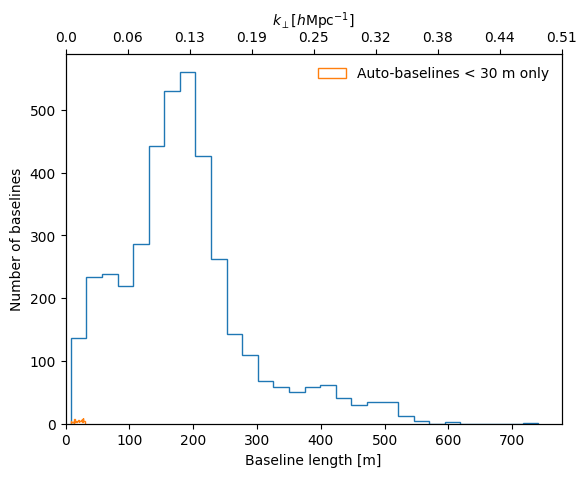

In [16]:
fig, ax = plt.subplots()
ax.hist(lens, histtype='step', bins=30, lw=2., ls='--')
ax.hist(red_lens, histtype='step', bins=30, lw=2., label=f'Auto-baselines < {max_bl_len} m only')
ax.set_xlabel('Baseline length [m]')
ax.set_xlim(left=0)
ax.set_ylabel('Number of baselines')
ax2 = ax.twiny()
ax2.set_xticks(ax.get_xticks(), labels=np.round(cosmo.bl_to_kperp(dic["avg_z"], little_h=True)*ax.get_xticks(), decimals=2))
ax2.set_xlabel(r'$k_\perp [h$Mpc$^{-1}$]')
ax.legend(frameon=False)

In [17]:
# Create a new PSpecData object which will be used to compute the delay PS
ds = hp.PSpecData(dsets=[uvd, uvd], wgts=[None, None], beam=uvb)
# build delay ps from baseline pairs constructed above
uvp = ds.pspec(
    bls1, bls2,
    dsets=(0, 1), 
    pols=[(dic['pol'], dic['pol'])],
    spw_ranges=spw_ranges,  # select a smaller bandwidth
    verbose=False
)

Casting complex values to real discards the imaginary part


The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


Text(0, 0.5, 'Baseline length [m]')

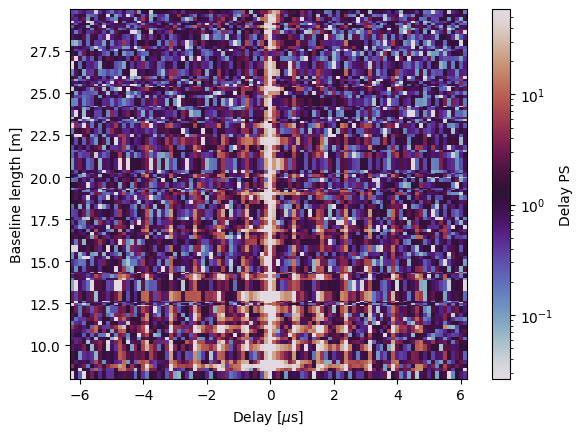

In [18]:
# plot
dat = np.copy(uvp.data_array[0][:, :, 0])
vmin = np.percentile(abs(dat), 2)
vmax = np.percentile(abs(dat), 98)

fig, ax = plt.subplots(1, 1)

#phases
im = ax.pcolormesh(
    uvp.dly_array*1e6,
    np.take(red_lens, red_groups),
	np.abs(dat),
	cmap='twilight',
    norm=colors.LogNorm(vmin=vmin, vmax=vmax),
)
cbar = fig.colorbar(im, ax=ax, label=f'Delay PS')
ax.set_xlabel(r'Delay [$\mu$s]')
ax.set_ylabel('Baseline length [m]')

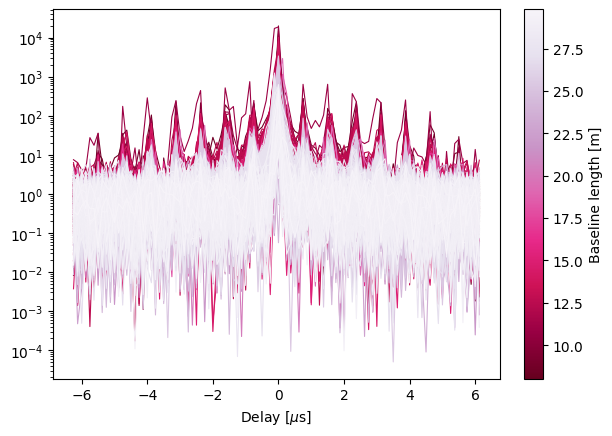

In [19]:
cmap = colormaps['PuRd_r']
norm = colors.Normalize(vmin=np.min(red_lens), vmax=np.max(red_lens))

fig, ax = plt.subplots(1, 1)
for i, blen in enumerate(np.take(red_lens, red_groups)):
    ax.semilogy(uvp.dly_array*1e6, np.abs(dat[i]), color=cmap(norm(blen)), lw=.8)
ax.set_xlabel(r'Delay [$\mu$s]')
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
plt.colorbar(sm, ax=ax, fraction=0.05, label='Baseline length [m]')
